# Replication of Ben S. Bernanke, Jean Boivin and Piotr Eliasz QJE 2005
Measuring the Effects of Monetary Policy: A Factor-Augmented Vector Autoregressive(FAVAR) Approach. The Quarterly Journal of Economics, Vol. 120, No. 1 (Feb., 2005), pp. 387-422
Francesco Franco, NOVA SBE Empirical Macroeconomics

# PART 1

In [9]:
'''Importing packages and functions''' 

import os                                # operating system
import pandas as pd                      # pandas
import numpy as np                       # numpy
from numpy import linalg as LA
#from numpy.linalg import inv, multi_dot  # linear algebra from numpy for PCA
import matplotlib.pyplot as plt          # figures
%matplotlib inline                       

In [10]:
'''Load data set'''

#Change to your directory and put csv in it
#os.chdir(r"C:\Users\ffranco\Dropbox\Work\Teaching\Empirical\Class6_2018\data")

df = pd.read_csv("nsbalpanel.csv",header=None)       #load data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Columns: 120 entries, 0 to 119
dtypes: float64(120)
memory usage: 479.1 KB


0        1        2        3        4       5        6        7    \
0  0.01340  0.00861  0.00732  0.00523  0.00952  0.0133  0.01880  0.03120   
1  0.00602  0.00492  0.00000  0.01940 -0.00475  0.0107  0.01390  0.02560   
2  0.01430  0.01450  0.01570  0.00640  0.01650  0.0258  0.01600  0.02730   
3  0.00829  0.00956  0.00476  0.02010  0.00000  0.0319  0.00564  0.02540   
4  0.00704  0.00714 -0.00476  0.00746 -0.00703  0.0233  0.00337 -0.00659   

       8        9    ...      110      111      112      113      114  \
0  0.04500  0.01740  ...  0.00473  0.00000  0.00000  0.00436  0.00000   
1  0.03870  0.01490  ...  0.00471 -0.00301  0.00524  0.00000  0.00000   
2  0.02970  0.03050  ...  0.00000  0.00000  0.00000  0.00434  0.00345   
3  0.03410  0.00892  ...  0.00468  0.00301  0.00261  0.00432  0.00344   
4 -0.00736 -0.00301  ...  0.00466  0.00000  0.00000  0.00000  0.00343   

       115      116      117      118   119  
0  0.00000  0.00000  0.00348  0.00462  95.8  
1  0.00000  0.00000 -0.00348  0.00917  96.4  
2  0.00000  0.00000  0.00694  0.00456  96.9  
3  0.00000  0.00000  0.00690  0.00000  97.5  
4  0.00325  0.00337  0.00343  0.00454  97.2  

[5 rows x 120 columns]

In [11]:
'''
   Data Description in Appendix1 page 416-420
   The transformation codes are:
   1:no transformation
   2:first difference
   4:logarithm
   5:first difference of logarithm.
   An asterisk *, next to the mnemonic, denotes a variable assumed to be slow-moving in the estimation
'''

# let us keep the indexes of the slow-moving variables
slowindex = list(range(0,53))+list(range(102,119)) # remember that index in python starts with 0, therefore
                                                     # need to take out 1 from numbers in appendix
                                                     # furthermore range is closed on the left and open on the right
        
xindex    = [15,107,77,80,95,92,73,101,16,48,50,25,47,117,53,61,70,119]

data_dict =  {0:'IPP',
              1:'IPF',
              2:'IPC',
              3:'IPCD',
              4:'IPCN'}

In [12]:
'''Transforming the data'''

stdffr =   # keep std of the ffr
df     = df.apply(lambda x: (x-x.mean())/x.std())

In [13]:
stdffr

3.201680743497916

Consider the case where you observe one factor without error $Y_t=ffr_t$
$$\mathcal{X}_{t}=\Lambda\left[\begin{array}{c}
Y_{t}\\
F_{t}
\end{array}\right]+\left[\begin{array}{c}
0\\
e_{t}
\end{array}\right]$$

In [14]:
'''Specification: what is observable'''

#df = df.rename(columns=data_dict) 

observables = [76]        #["ffr"]
Y = df.loc[:,observables]
X = df.loc[:,df.columns.difference(observables)]

In [15]:
''' Parameters '''

num_factors = 3                 # Change to increase number of factors to be extracted
N           = X.shape[1]        # number of series 
T           = X.shape[0]        # number of observations
M           = Y.shape[1]        # number of series considered observables factors
K           = num_factors
# number of periods for IRFS 
num_impulses = 40
num_lags     = 13
nrep1        = 1
nrep2        = 100
nsteps       = 48

## PCA computing the eigenvalues and eigenvectors
This is the Linear Algebra algorithm that is widely used because numerically stable. In the notes we have that • The estimators of $F_{t}$ and $\Lambda$ solve the minimization problem$$\min_{\left\{ F_{i}\right\} _{i=1}^{T},\Lambda}\left(NT\right)^{-1}\sum_{t=1}^{T}\left[\mathcal{X}_{t}-\Lambda F_{t}\right]'\left[\mathcal{X}_{t}-\Lambda F_{t}\right]$$subject to $N^{-1}\Lambda'\Lambda=I_{r}.$

Under our simplified assumptions $\hat{F}_{t}=N^{-1}\hat{\Lambda}'\mathcal{X}_{t}$ and $\hat{\Lambda}$ is the matrix of eigenvectors (multiplied by $\sqrt{N}$) of the sample variance matrix of  $\mathcal{X}_{t}.$ 
Remember that a square matrix can be decomposed as $$\mathcal{X}'\mathcal{X}=VSV^{-1}$$ where $V$ are the eigenvectors and $S$ the eigenvalues. Now our covariance matrix is $$\frac{\mathcal{X}'\mathcal{X}}{N}$$ therefore $\Lambda=\sqrt{N}V$

In [16]:
def extract_eig(x,nf):
    
    # Compute the factors with the eigenvalues eigenvectors decomposition
    # Inputs:  x the data
    #          nf number of factors
    # Outputs: lam the factor loadings
    #          fac the factors    
    x=np.array(x)
    xx=x.T@x 
    s, V = LA.eig(xx)
    W = V[:,:3]
    lam = W*np.sqrt(x.shape[1])
    fac = x@lam/x.shape[1]
    return fac, lam 

## PCA using the SVD decomposition
The SVD decomposition is practical because always exists and says that $\mathcal{X}=VSU'$ where $V$ and $U$ are orthonormals. Therefore $$\mathcal{X}'\mathcal{X}=VSU'USV'=VS^{2}V'$$ and we can see that $V$ is our $\Lambda$

In [17]:
def extract_svd(x,nf):
    
    # Compute the factors with the SVD
    # Inputs:  x the data
    #          nf number of factors
    # Outputs: lam the factor loadings
    #          fac the factors    
    
    x = np.array(x)
    U, s , V = LA.svd(x)
    W = V.T[:,:nf]
    lam = W*np.sqrt(x.shape[1])
    fac = x@lam/x.shape[1]
    
    return fac, lam 

## Slow-R-Fast identification scheme
the Bernanke, Boivin, and Eliasz (2005) implementation of the slow-R-fast identification scheme starts from 
$$\mathcal{X}_{t}=\Lambda F_{t}+e_{t}$$
and divide the factors into slow-moving and fast-moving
$$\begin{bmatrix}\mathcal{X}_{t}^{s}\\
\mathcal{X}_{t}^{f}
\end{bmatrix}=\begin{bmatrix}\Lambda_{ss} & 0 & 0\\
\Lambda_{fs} & \Lambda_{fr} & \Lambda_{ff}
\end{bmatrix}\begin{bmatrix}F_{t}^{s}\\
R_{t}\\
F_{t}^{f}
\end{bmatrix}+e_{t}$$
or $$\mathcal{X}_{t}^{s}=\Lambda_{ss}F_{t}^{s}+e_{t}^{s}$$ $$\mathcal{X}_{t}^{f}=\Lambda_{fs}F_{t}^{s}+\Lambda_{fr}R_{t}+\Lambda_{ff}F_{t}^{f}+e_{t}^{f}$$
And
$$\begin{bmatrix}F_{t}^{s}\\
R_{t}\\
F_{t}^{f}
\end{bmatrix}=\Phi(L)\begin{bmatrix}F_{t-1}^{s}\\
R_{t-1}\\
F_{t-1}^{f}
\end{bmatrix}+\begin{bmatrix}\eta_{t}^{s}\\
\eta_{t}^{r}\\
\eta_{t}^{f}
\end{bmatrix}$$

In the paper (p.405) they decribe the following procedure:
- get $F_{t}$ from the $\mathcal{X}_{t}$ whole dataset.
- get $F_{t}^{s}$ from the $\mathcal{X}_{t}^{s}$ sub-dataset.
- regress $F_{t}=\beta_{s}F_{t}^{s}+\beta_{r}R_{t}+u_{t}$
- $F_{t}^{r}=F_{t}-\hat{\beta}_{r}R_{t}$

In [25]:
def facrot(F,Ffast,Fslow):
    
    # computes the rotation of the factors as described in p.405 of the paper
    # Inputs:  F:      Unrestricted PC estimates (from all the dataset)
    #          Ffast:  Factors assumed to be fast moving (e.g. policy instrument)
    #          Fslow:  Proxy of the slow moving factors
    # Outputs: Fr: rotation of factors
    
    F, Fslow, Ffast = np.array(F),np.array(Fslow),np.array(Ffast)
    Fslow           = np.hstack([Fslow, Ffast])
    betas = LA.inv(Fslow.T@Fslow)@Fslow.T@F
    Fr    = F - np.dot(Ffast,betas[num_factors:,:])
    Fr    = pd.DataFrame(Fr)
    
    return Fr

In [28]:
#xir=df.loc[:,df.columns[xindex]]
F0, Lf0 = extract_svd(X,K)
#u0 = X -np.dot(F0,Lf0.T)
xslow = df.loc[:,df.columns[slowindex]]
Fslow0, Lfslow0 = extract_svd(xslow,K)
Fr0 = facrot(F0,Y,Fslow0)
X = pd.concat([Fr0, Y],axis=1)


In [29]:
XLAG     = pd.DataFrame()
for i in range(1,num_lags+1):
    XLAG = pd.concat([XLAG,X.shift(i).add_suffix("-"+str(i))],axis=1)

In [34]:
#change names to frames that we modify    
X2       = X.iloc[num_lags:,:]
XLAG2    = XLAG.iloc[num_lags:,:]
num_vars = X2.shape[1]
num_obs  = XLAG2.shape[0]

#Building arrays for using OLS
X3       = np.array(X2)
XLAG3    = np.array(XLAG2)

#VAR - standard OLS
Bhat     = LA.inv(XLAG3.T@XLAG3)@XLAG3.T@X3

In [35]:
num_vars, num_obs

(4, 498)

In [36]:
4, T

(4, 511)

In [37]:
#Estimated errors
EPS = (X3 - XLAG3@Bhat)
num_obs = T
num_vars = 4
#estimated covariance matrix
Omegahat = EPS.T@EPS/(num_obs - num_lags*num_vars - 1)
# Putting problem in canonical form (VAR(8) into VAR(1))
# c_x(t) = c_Bhat*c_x(t-1) + c_G*eta(t)
# c_Bhat = [ Bhat' ; eye((n_lags-1)*n_vars) zeros((n_lags-1)*n_vars,n_vars) ] ;

c_Bhat = np.vstack((Bhat.T,np.hstack((np.identity((num_lags-1)*num_vars),np.zeros([(num_lags-1)*num_vars,num_vars]))))) 


## Identification
$$
\begin{bmatrix}\eta_{t}^{s}\\
\eta_{t}^{r}\\
\eta_{t}^{f}
\end{bmatrix}=\begin{bmatrix}A_{ss} & 0 & 0\\
A_{rs} & 1 & 0\\
A_{fs} & A_{fr} & A_{ff}
\end{bmatrix}\begin{bmatrix}\epsilon_{t}^{s}\\
\epsilon_{t}^{r}\\
\epsilon_{t}^{f}
\end{bmatrix}$$

In [48]:
A0 = LA.cholesky(Omegahat)
d  = np.zeros(A0.shape)
np.fill_diagonal(d,np.diag(A0))
A0 = np.dot(np.linalg.inv(d),A0)

In [49]:
#IRFs
'''IRFs are stored in a 3-dimensional array. Dimension 1 is time. Dimension
    2 is variable, and 3 is shock. So IRF(:,2,1) gives the impulse response
    of the second variable to the first shock.''' 
    
IRF  = np.zeros([num_impulses,num_vars,num_vars])
Temp = np.identity(c_Bhat.shape[0])

psi  = []
for t in range(num_impulses):
    psi_t = Temp[:num_vars,:num_vars] 
    IRF[t,:,:] = psi_t@A0  # store the IRF
    Temp = c_Bhat@Temp            # computes the exponent of the matrix
    


In [40]:
# 
shock = np.hstack([np.zeros([1,K+M-1]), np.ones([1,1])*0.25/stdffr])
shock = shock.T
IRF   = IRF@shock    
irf   = pd.DataFrame({i:IRF[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe

## recover Impulse response from variables of the dataset
Now you have the factors therefore you can estimate the loadings with OLS $$\mathcal{X}_{t}=\hat{\beta}F_{t}^{r}+\hat{\beta}R_{t}$$

In [41]:
xir   = df.loc[:,df.columns[xindex]]
bx0   = LA.inv(X.T@X)@X.T@xir
irf_x = irf@bx0

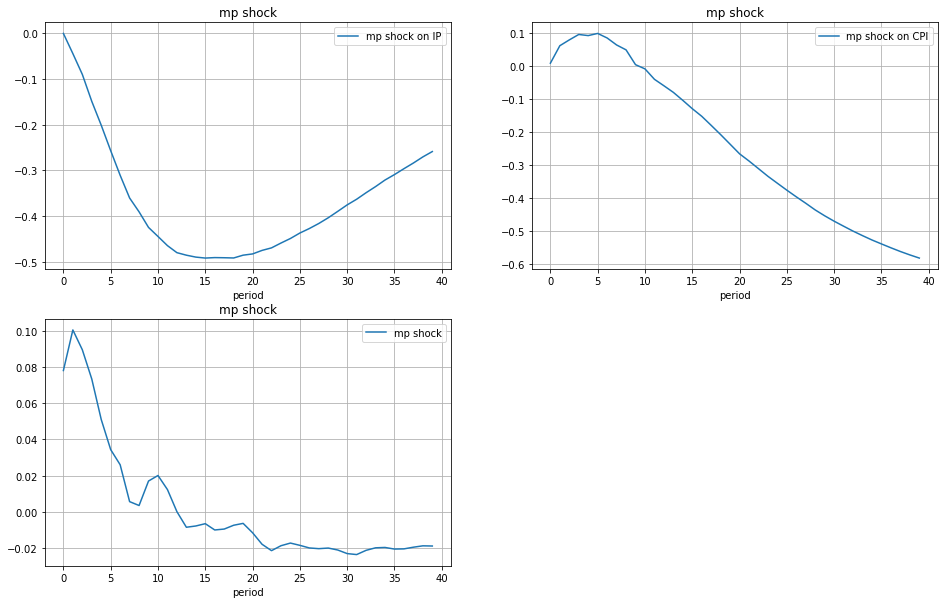

In [42]:
# Plot the IRFs

plt.figure(figsize=(16,10))

plt.subplot(221)
plt.plot(np.exp(np.cumsum(irf_x[15]))-1,label='mp shock on IP')
plt.legend()
plt.xlabel('period')
plt.title('mp shock')
plt.grid()

plt.subplot(222)
plt.plot(np.exp(np.cumsum(irf_x[107]))-1,label='mp shock on CPI')
plt.legend()
plt.xlabel('period')
plt.title('mp shock')
plt.grid()

plt.subplot(223)
plt.plot(irf[3],label='mp shock')
plt.legend()
plt.xlabel('period')
plt.title('mp shock')
plt.grid()
